In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def read_data(file_name):
    trainY=[]
    trainX=[]
    with open(file_name) as f:
        temp = f.read().splitlines()
    temp = list(filter(None, temp))

    for line in temp:
        if (len(line))==1:
            y=map(int, line)
            trainY.append(int(line))
        else:
            trainX.append(np.array(list(map(int, line))))

    trainX=np.array(trainX).flatten()
    trainX=trainX.reshape((len(trainY),256))
    return trainX,np.array(trainY)

def shuffle_dataset(x,y):
    """
    Shuffles two arrays in the same order.
    """
    randomize = np.arange(len(x))
    randomize=np.random.shuffle(randomize)
    return np.squeeze(x[randomize]),np.squeeze(y[randomize])
trainX,trainY=read_data("traicom.txt")
testX,testY=read_data("testcom.txt")
shape_of_inputs=len(trainX[0])+1 #+1 bias term
shape_of_outputs=len(set(trainY))


In [3]:
weights=np.random.uniform(-0.001,0.001,(shape_of_outputs,shape_of_inputs)) #initialize weights
def one_hot_code(y):
    """
    Converts instance or array to one hot code encoding.
    e.g. 5->0000010000 (lenght of array is shape of output which is 10 in this case)
    """
    if isinstance(y,list) or isinstance(y,np.ndarray): #if it is a list, iterate over it and return Nx10 array
        coded=[]
        for instance in y:
            a=np.zeros(shape_of_outputs,dtype=int)
            a[instance]=1
            coded.append(a)
        return coded
    else: #if its a scalar, return 1x10 array
        a=np.zeros(shape_of_outputs,dtype=int)
        a[y]=1
        return a
def predict(testX):
    """
    Predicts given dataset inputs. Returns as class numbers(0,1,2,3) (not one hot codes)
    """
    predictions=[]
    for x in testX:
        x=np.insert(x,0,1)# +1 bias
        y=predict_an_instance(x)
        y=np.argmax(y)
        predictions.append(y)
    return predictions
def predict_without_one_hot_code(testX):
    predictions=[]
    for x in testX:
        x=np.insert(x,0,1)# +1 bias
        y=predict_an_instance(x)
        predictions.append(y)
    return predictions


def predict_an_instance(x):            
    """
    Predicts given input instance using global out scope weights 2d matrix and softmax function. 
    Bias term should be added two instance before calling this function
    """
    o=np.zeros(shape_of_outputs,dtype=np.float64)
    for i  in range(shape_of_outputs):
        for j in range(shape_of_inputs):
             o[i]+=((weights[i][j]*x[j])+weights[i][0])
            #o[i]=np.exp(o[i])
        y=np.zeros(shape_of_outputs,dtype=np.float64)
        
    o -= np.max(o) # prevent overflow on taking exponent
    y = np.exp(o) / np.sum(np.exp(o)) 
    return y
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    """
    
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce
def calculate_accuracy(x,y):
    """
    Calculates accuracy on given dataset. 
    """
    predictions=predict(x)
    tp=np.count_nonzero(predictions==y) # if predictions==y then it will be true which is non zero.
    return tp/len(x)

epochs=30
learning_rate=0.01
def calculate_recall(x,y):
    """
    Calculates unweighted averaged recall.
    """
    correct_instances=np.zeros(shape_of_outputs,dtype=np.int32)#these two arrays holds ...
    number_of_instances=np.zeros(shape_of_outputs,dtype=np.int32)#...the Ni and Nc to calculate UAR
    predictions=predict(x)
    uar=np.zeros(shape_of_outputs,dtype=np.float64)
    for ix,iy in zip(predictions,y):
        number_of_instances[iy]+=1
        if ix==iy:
            correct_instances[iy]+=1
    for c,n,i in zip(correct_instances,number_of_instances,range(shape_of_outputs)):
        uar[i]=c/n
    return np.mean(uar)


In [4]:
metrics=[] #holds a dict for each epoch
#metric_dict={"train_error":.0,"test_error":.0,"train_acc":.0,"test_acc":.0,"train_uar":.0,"test_uar":.0}  dict shape of metric 

for m in range(epochs):     
    shuffled_X,shuffled_Y=shuffle_dataset(trainX,trainY)
    for x,r in zip(shuffled_X,shuffled_Y):
        x=np.insert(x,0,1)# +1 bias
        y=predict_an_instance(x)
        for i in range(shape_of_outputs):
            for j in range(shape_of_inputs):
                weights[i][j]+=learning_rate*(one_hot_code(r)[i]-y[i])*x[j] #update weights            
    acc_train=calculate_accuracy(shuffled_X,shuffled_Y)
    acc_test=calculate_accuracy(testX,testY)
    uar_train=calculate_recall(shuffled_X,shuffled_Y)
    uar_test=calculate_recall(testX,testY)
    train_ce=cross_entropy(predict_without_one_hot_code(shuffled_X),one_hot_code(shuffled_Y))
    test_ce=cross_entropy(predict_without_one_hot_code(testX),one_hot_code(testY))
    
    metric=[train_ce,test_ce,acc_train,acc_test,uar_train,uar_test]
    metrics.append(metric)
    print("Epoch: "+str(m+1)+" Training Error: %.4f"%train_ce +" Test Error: %.4f"%test_ce+ " Training Accuracy: %.4f"%acc_train +" Test Accuracy: %.4f" 
          %acc_test +" UAR Training: %.4f" %uar_train+ " UAR Test: %.4f"%uar_test)
    
                    
    learning_rate+=0.001
metrics=np.array(metrics)

Epoch: 1 Training Error: 0.4532 Test Error: 0.5558 Training Accuracy: 0.8717 Test Accuracy: 0.8300 UAR Training: 0.8717 UAR Test: 0.8300
Epoch: 2 Training Error: 0.2817 Test Error: 0.3916 Training Accuracy: 0.9183 Test Accuracy: 0.8817 UAR Training: 0.9183 UAR Test: 0.8817
Epoch: 3 Training Error: 0.2064 Test Error: 0.3226 Training Accuracy: 0.9483 Test Accuracy: 0.9000 UAR Training: 0.9483 UAR Test: 0.9000
Epoch: 4 Training Error: 0.1600 Test Error: 0.2801 Training Accuracy: 0.9600 Test Accuracy: 0.9150 UAR Training: 0.9600 UAR Test: 0.9150
Epoch: 5 Training Error: 0.1303 Test Error: 0.2531 Training Accuracy: 0.9750 Test Accuracy: 0.9200 UAR Training: 0.9750 UAR Test: 0.9200
Epoch: 6 Training Error: 0.1101 Test Error: 0.2346 Training Accuracy: 0.9767 Test Accuracy: 0.9267 UAR Training: 0.9767 UAR Test: 0.9267
Epoch: 7 Training Error: 0.0946 Test Error: 0.2195 Training Accuracy: 0.9817 Test Accuracy: 0.9317 UAR Training: 0.9817 UAR Test: 0.9317
Epoch: 8 Training Error: 0.0819 Test Erro

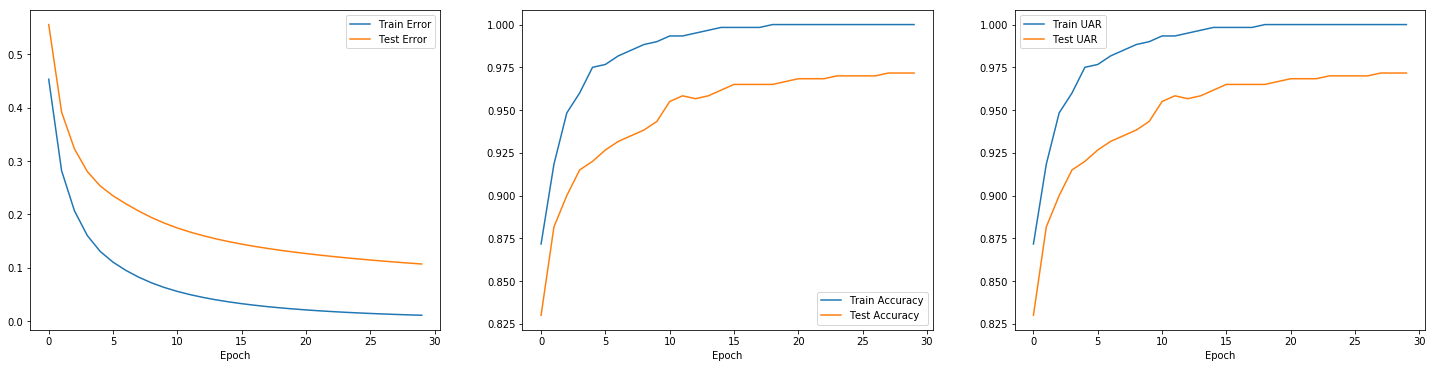

In [5]:
fig=plt.figure(figsize=(25,20))

m=metrics.T
labels=["train_error","test_error","train_acc","test_acc","train_uar","test_uar"]
ax=fig.add_subplot(331)
ax.set_xlabel("Epoch")
ax.plot(m[0],label="Train Error")
ax.plot(m[1],label="Test Error")
plt.legend()

ax=fig.add_subplot(332)
ax.set_xlabel("Epoch")
ax.plot(m[2],label="Train Accuracy")
ax.plot(m[3],label="Test Accuracy")
plt.legend()

ax=fig.add_subplot(333)
ax.set_xlabel("Epoch")
ax.plot(m[4],label="Train UAR")
ax.plot(m[5],label="Test UAR")
plt.legend()

plt.show()

In [7]:
train_conf_matrix=np.zeros((shape_of_outputs,shape_of_outputs),dtype=np.int32)
for x,y in zip(predict(trainX),trainY):
    train_conf_matrix[x][y]+=1
test_conf_matrix=np.zeros((shape_of_outputs,shape_of_outputs),dtype=np.int32)
for x,y in zip(predict(testX),testY):
    test_conf_matrix[x][y]+=1


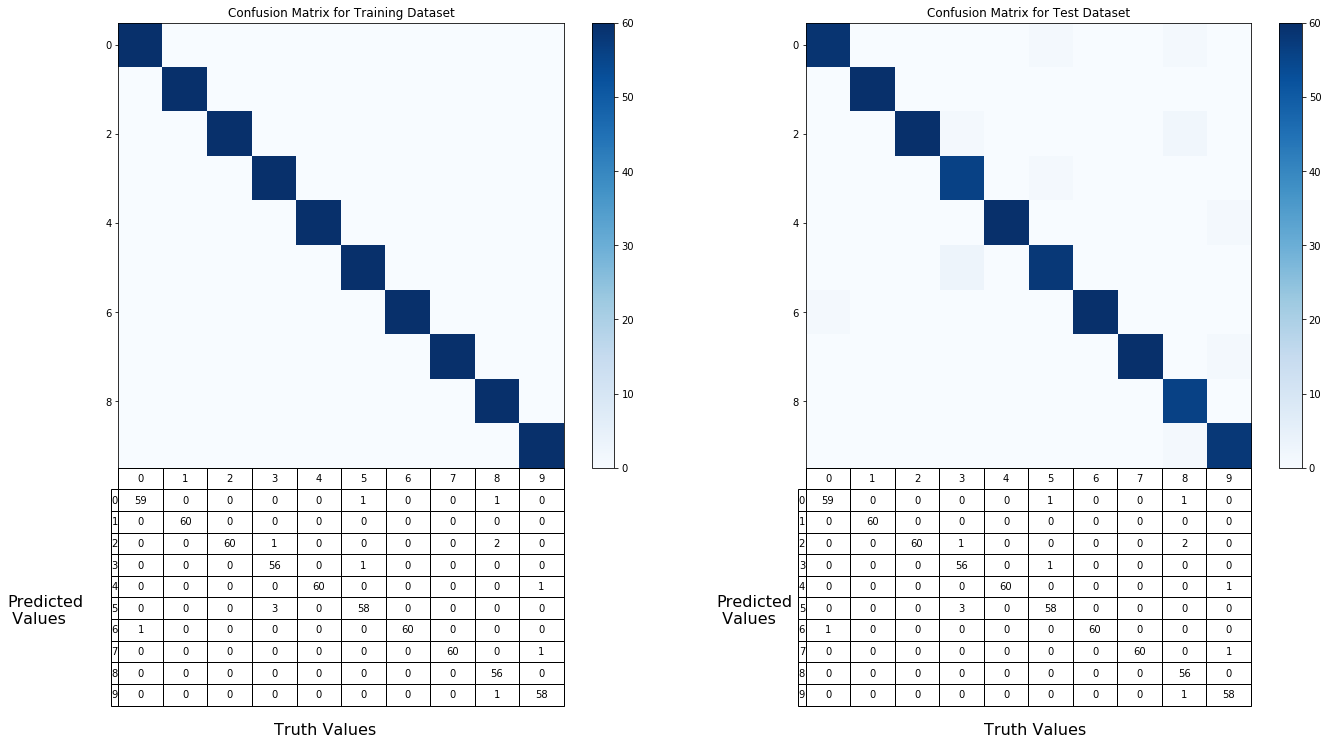

In [10]:
fig=plt.figure(figsize=(25,20))

ax=fig.add_subplot(221)
im=ax.imshow(train_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix for Training Dataset")
plt.colorbar(mappable=im,ax=ax)
table=plt.table(cellText=test_conf_matrix,rowLabels=range(shape_of_outputs),
colLabels=range(shape_of_outputs),
cellLoc = 'center', rowLoc = 'center',loc='bottom')
table.scale(1, 2)
ax.xaxis.set_visible(False) 
plt.text(-3,13,'Predicted\n Values',size=16)
plt.text(3,15.5,'Truth Values',size=16)

ax=fig.add_subplot(222)
im=ax.imshow(test_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix for Test Dataset")
plt.colorbar(mappable=im,ax=ax)
table=plt.table(cellText=test_conf_matrix,rowLabels=range(shape_of_outputs),
colLabels=range(shape_of_outputs),
cellLoc = 'center', rowLoc = 'center',loc='bottom')

plt.subplots_adjust(left=0.2, bottom=0.2)
ax.xaxis.set_visible(False) 
plt.text(-2.5,13,'Predicted\n Values',size=16)
plt.text(3.5,15.5,'Truth Values',size=16)
table.scale(1, 2)

plt.show()